# Sweet Butter 🧈

Sweet Butter is a shortest paths problem by Greg Galperin from the [USACO training pages](https://train.usaco.org/):

> *Farmer John has discovered the secret to making the sweetest butter in all of Wisconsin: sugar. By placing a sugar cube out in the pastures, he knows the cows will lick it and thus will produce super-sweet butter which can be marketed at better prices. Of course, he spends the extra money on luxuries for the cows.*
>
> *FJ is a sly farmer. Like Pavlov of old, he knows he can train the cows to go to a certain pasture when they hear a bell. He intends to put the sugar there and then ring the bell in the middle of the afternoon so that the evening's milking produces perfect milk.*
>
> *FJ knows each cow spends her time in a given pasture (not necessarily alone). Given the pasture location of the cows and a description of the paths that connect the pastures, find the pasture in which to place the sugar cube so that the total distance walked by the cows when FJ rings the bell is minimized. FJ knows the fields are connected well enough that some solution is always possible.*

Rephrased:

> Given a connected undirected weighted graph with some active nodes, find the node that minimizes the total distance taken from every active node to it.

The key concepts for this problem are:

- **Node**: pasture.
- **Weighted Edge**: length of a direct connection between two pastures. 
- **Undirected**: edges can be traversed in both directions.
- **Shortest Path**: minimal sum of edge weights to get from pasture A to pasture B. (Other problems may want this as a number of edges or sequence of nodes taken.)
- **Adjacency List**: a data structure to represent a [graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29). Each node *x* in the graph is assigned an [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list) that consists of nodes to where there is an edge from *x*.
- **Dijkstra's Algorithm**: an algorithm for finding the shortest paths from a starting node to all other nodes.  
 - **Greedy**: a type of algorithm (e.g. Dijkstra's) that constructs its solution by always making a choice that looks best at the moment.
 - **Heap**: a data structure that gives easy access and removal of the minimum or maximum element. Used to implement a priority queue.

Related concepts are:

- **Adjacency Matrix**: a data structure to represent a graph.
- **Floyd-Warshall Algorithm**: a shortest paths algorithm.

## Imports, Types, and Utility Functions

In [1]:
import matplotlib.pyplot as plt
import networkx          as nx
import heapq
from typing      import *
from collections import defaultdict

Cow  = Dict[int, int]               # A cow and its pasture
Edge = Tuple[int, int]              # A pasture and connection length
Adj  = DefaultDict[int, List[Edge]] # Adjacency list, e.g. {1: [(2, 1), (3, 5)], 2: [(1, 1), (3, 7), (4, 3)], ...}
Data = Tuple[Cow, Adj]              # Data read from input
Dist = Dict[int, int]               # Shortest paths

In [2]:
def read_input(file: str='butter.in') -> Data:
    """Store cow locations and adjacency list from input data."""
    cow, adj = {}, defaultdict(list)
    with open(file) as f:
        C, V, E = map(int, f.readline().split())     # cows, vertices (nodes), edges
        for i in range(1, C + 1):
            cow[i] = int(f.readline())
        for _ in range(E):
            u, v, w = map(int, f.readline().split()) # undirected edge connecting u and v with weight w
            adj[u].append((v, w))
            adj[v].append((u, w))
    return cow, adj

In [3]:
def draw_graph(data: Data, is_large: bool=False):
    """Visualize an adjacency list and show cows in each node."""
    cow, adj = data
    G = nx.Graph()
    for u in adj:
        G.add_node(u, cow=0)
        for edge in adj[u]:
            v, w = edge[0], edge[1]
            G.add_edge(u, v, weight=w)
    for i in cow:
        G.nodes[cow[i]]['cow'] += 1
        
    if is_large: 
        plt.figure(1, figsize=(75, 75))
        
    # draw nodes
    layout = nx.circular_layout(G) # positions for all nodes
    nx.draw(G, pos=layout, with_labels=True, node_color="lightgreen")
    
    # draw cow attribute label above nodes
    pos_attrs = {}                 # positions for cow labels
    for u, xy in layout.items(): 
        pos_attrs[u] = (xy[0], xy[1] + 0.12) 
    cow_labels = {}                    
    for u, val in nx.get_node_attributes(G, 'cow').items():
        cow_labels[u] = '' if is_large else "🐮 x" + str(val) # no cow labels on large graphs; looks nicer
    nx.draw_networkx_labels(G, pos=pos_attrs, labels=cow_labels)
    
    # draw edge weights
    weight_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=weight_labels) 
    plt.show()

## Input

The first line contains the number of cows, pastures, and edges respectively. The next cow number of lines is each cow and its pasture. Followed by lines containing connected pastures and the distance between them. 

> 3 4 5  
> 2  
> 3  
> 4  
> 1 2 1  
> 1 3 5  
> 2 3 7  
> 2 4 3  
> 3 4 5

Cows and their pasture are stored in a dictionary and an adjacency list stores the graph of pastures and connections.

In [4]:
read_input()

({1: 2, 2: 3, 3: 4},
 defaultdict(list,
             {1: [(2, 1), (3, 5)],
              2: [(1, 1), (3, 7), (4, 3)],
              3: [(1, 5), (2, 7), (4, 5)],
              4: [(2, 3), (3, 5)]}))

Here is the sample input visualized.

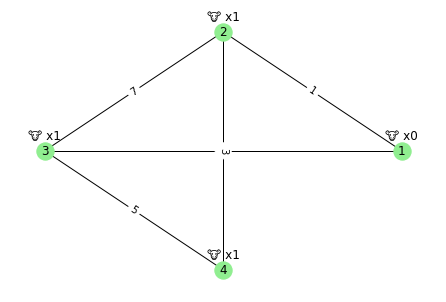

In [5]:
draw_graph(read_input())

Tougher inputs will be tested. [Test case 9](https://raw.githubusercontent.com/wilsjame/weblog/butter/docs/source/_ipynb/butter/butter9.in) is the toughest with 500 cows, 800 pastures, and 1450 connections.

Here is test case 9 visualized.

In [6]:
# draw_graph(read_input('butter9.in'), is_large=True)

<img align="left" width="350" height="350" src="butter9_resized.png" title="🐮">

Drawing the graph takes too long to load in some notebooks. Uncomment the line to try it or download the full-size image [butter.png](https://github.com/wilsjame/weblog/blob/butter/docs/source/_ipynb/butter/butter9.png) (18 MB).

## Output

Find the minimum distance cows must walk to a pasture with a sugar cube.

For the sample input shown above the answer is: **8**

Putting the cube in pasture 4 means: cow 1 walks 3 units; cow 2 walks 5 units; cow 3 walks 0 units -- a total of 8.

For test case 9 the answer is: **164290**

## Shortest Paths: Dijkstra

Dijkstra's algorithm finds the shortest paths from a source node to all nodes in a graph. It's greedy and facilitates this with a priority queue. The cool thing is every node needs only be processed once. Assuming we have the graph, three data structures are used:

- An array `distance[]` stores the distance from the source to every node. Every node's initial distance is infinity.
- An array `processed[]` keeps track of processed nodes. Once a node is processed it cannot be visited again and its distance is final. Initially false for every node.
- A priority queue `min_pq` provides the node to process next. When a node is processed its neighbors are added. Nodes are ordered by their distance value.

Set the source node distance `distance[source] = 0` and add the source and its distance to the priority queue `min_pq.push((0, source))`. Now, enter a loop until the queue is empty. The loop pops the minimum distance node from the queue `cur = min_pq.pop()` and processes it `processed[cur] = True`. Sweet one less node to go! Iterate the current node's neighbors. Skip neighbors that have been processed. For neighbors not yet processed we update their distances and add them to the queue. It's greedy `distance[neighbor] = min(distance[neighbor], distance[cur] + cur_to_neighbor_edge_weight)` and `min_pq.push(distance[neighbor], neighbor)`. When the queue is empty all nodes are processed and the loop terminates. `distance[]` holds the shortest paths for each node to the source. The worst-case performance is O(E\*log(N)) where E is the number of edges and N is the number of nodes. We visit each node at most E times and for each visit, the priority queue has at most N nodes. 

In [7]:
def dijkstra(source: int, data: Data) -> Dist:
    """Find shortest paths from source to each node in adjacency graph."""
    _, adj = data
    nodes = len(adj)
    distance = dict.fromkeys([i for i in range(1, nodes + 1)], float("inf"))
    processed = dict.fromkeys([i for i in range(1, nodes + 1)], False)
    min_pq = []
    distance[source] = 0
    heapq.heappush(min_pq, (0, source))                    # distance before node for heap ordering
    while len(min_pq) > 0:
        _, cur = heapq.heappop(min_pq)
        processed[cur] = True
        for neighbor in adj[cur]:
            node, cur_to_node_dist = neighbor              # node before distance in adjacency list
            if processed[node] is True:
                continue
            distance[node] = min(distance[node], distance[cur] + cur_to_node_dist)
            heapq.heappush(min_pq, (distance[node], node)) # distance before node for heap ordering
    return distance

## Solve

We try each node as the sugar cube source to find the minimum distance cows must walk. Running time is O(C\*E\*log(N)) where C is cows, E edges, and N nodes. 

In [8]:
def solve(data: Data) -> int:
    """Find the minimum distance cows must walk."""
    cow, adj = data
    res = float("inf")
    nodes = len(adj)
    for source in range(1, nodes + 1):
        shortest_paths = dijkstra(source, data)
        total = 0
        for i in cow:
            total += shortest_paths[cow[i]]
        res = min(res, total)
    return res

In [9]:
solve(read_input()) == 8

True

In [10]:
%time solve(read_input('butter9.in')) == 164290

Wall time: 6.34 s


True

### Go Fast

Test case 9 isn't *the* toughest input. There is a test case 10! The USACO grader allotted runtime is 1 second. The approach discussed here has the correct run time complexity O(C\*E\*log(N)), but the implementation falls short and fails the <1 second mark. 

![test case 9 py](usaco_grader_py.png)

For starters, we can speed up our Dijkstra implementation. Sometimes the queue might pop an already processed node. When this happens there is no point processing it again because its shortest distance is already set. An if statement should do the trick.

In [11]:
def dijkstra(source: int, data: Data) -> Dist:
    """Find shortest paths from source to each node in adjacency graph."""
    _, adj = data
    nodes = len(adj)
    distance = dict.fromkeys([i for i in range(1, nodes + 1)], float("inf"))
    processed = dict.fromkeys([i for i in range(1, nodes + 1)], False)
    min_pq = []
    distance[source] = 0
    heapq.heappush(min_pq, (0, source))                        # distance before node for heap ordering
    while len(min_pq) > 0:
        _, cur = heapq.heappop(min_pq)
        if processed[cur] == False: # <------------------------- speed up        
            processed[cur] = True
            for neighbor in adj[cur]:
                node, cur_to_node_dist = neighbor              # node before distance in adjacency list
                if processed[node] is True:
                    continue
                distance[node] = min(distance[node], distance[cur] + cur_to_node_dist)
                heapq.heappush(min_pq, (distance[node], node)) # distance before node for heap ordering
    return distance

In [12]:
%time solve(read_input('butter9.in')) == 164290

Wall time: 1.39 s


True

Sweet! A considerable speed up. Additional improvements could be writing your own Fibonacci heap discussed on the [Dijkstra\'s algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) wiki page or storing the graph as an adjacency matrix. Trying to optimize look-ups by using list indices and values in place of a dict hashing keys to values. Implementing other search algorithms. And of course, experimenting with different languages. 

![test case 10 cpp](usaco_grader_cpp.png "On average, PyPy is 4.2 times faster than CPython!")

Don't forget, on average, PyPy is 4.2 times faster than CPython! 